## Kütüphanelerin Yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from curl_cffi import requests
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Ortam Ayarları

In [2]:
# Genel Görünüm Ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', '{:.4f}'.format)

## Veri Kazıma

In [3]:
def new_session():
    """
    Chrome tarayıcı gibi davranarak yeni bir oturum başlatır.
    """
    session = requests.Session(impersonate="chrome")
    return session

In [ ]:
def search_api(session: requests.Session, stock: str, startdate: str, enddate: str):
    """
    Belirtilen hisse senedi sembolü ve tarih aralığı için veri almak amacıyla bir istek gönderir
    ve dönen JSON verisini bir DataFrame olarak döndürür.

    Parametreler:
    session (requests.Session): HTTP isteği göndermek için kullanılan requests oturumu.
    stock (str): Hisse senedinin kodu.
    startdate (str): Başlangıç tarihi (YYYY-MM-DD formatında).
    enddate (str): Bitiş tarihi (YYYY-MM-DD formatında).
    """
    url = f" " # Bu alana stock verisi çekilecek url bilgisi yazılacak.
    response = session.get(url)
    response.raise_for_status()
    json_data = response.json()
    return create_df(json_data)

In [5]:
def create_df(json_data):    
    """
    Bu fonksiyon, JSON formatındaki veriyi alır ve DataFrame'e dönüştürür.

    Parametreler:
    json_data (dict): JSON formatında veri

    Dönen Değer:
    DataFrame: JSON verisini içeren DataFrame.
    """
    data = [] 
    for value_data in json_data['value']:
        row = {key: value for key, value in value_data.items()}
        data.append(row)  
    df = pd.DataFrame(data)
    return df

In [ ]:
stock = 'KOZAL' # Hisse Kodu 
startdate = '28-11-2019' # Başlangıç Tarihi
enddate = '28-11-2024' # Bitiş Tarihi

In [7]:
session = new_session()
df = search_api(session, stock, startdate, enddate)

## Veri Setine İlk Bakış

In [8]:
df.head(10)

,HGDG_HS_KODU,HGDG_TARIH,HGDG_KAPANIS,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_ENDEKS_KODU,END_TARIH,END_SEANS,END_DEGER,DD_DOVIZ_KODU,DD_DT_KODU,DD_TARIH,DD_DEGER,DOLAR_BAZLI_FIYAT,ENDEKS_BAZLI_FIYAT,DOLAR_HACIM,SERMAYE,HG_KAPANIS,HG_AOF,HG_MIN,HG_MAX,PD,PD_USD,HAO_PD,HAO_PD_USD,HG_HACIM,DOLAR_BAZLI_MIN,DOLAR_BAZLI_MAX,DOLAR_BAZLI_AOF
0,KOZAL,28-11-2019,3.5157,3.5044,3.4801,3.5253,44070567.0000,01,1574888400000,2,1071.2618,USD,01,1574888400000,5.7682,0.6095,0.0033,7640263.3404,152500000.0000,73.9000,73.6620,73.1500,74.1000,11269750232.6965,1953772447.6781,3379798094.7857,585936357.0586,44070567.0000,0.6033,0.6112,0.6075
1,KOZAL,29-11-2019,3.4920,3.5000,3.4777,3.5490,53901233.0000,01,1574974800000,2,1069.0368,USD,01,1574974800000,5.7507,0.6072,0.0033,9372986.4190,152500000.0000,73.4000,73.5690,73.1000,74.6000,11193500232.6965,1946458732.4494,3356930719.7857,583742973.8616,53901233.0000,0.6047,0.6171,0.6086
2,KOZAL,02-12-2019,3.6371,3.5971,3.4967,3.6918,153096964.0000,01,1575234000000,2,1080.0430,USD,01,1575234000000,5.7529,0.6322,0.0034,26612137.1830,152500000.0000,76.4500,75.6110,73.5000,77.6000,11658624534.6069,2026564782.0416,3496421497.9286,607766778.1343,153096964.0000,0.6078,0.6417,0.6253
3,KOZAL,03-12-2019,3.6585,3.6960,3.6180,3.7631,139328166.0000,01,1575320400000,2,1067.8987,USD,01,1575320400000,5.7468,0.6366,0.0034,24244477.9703,152500000.0000,76.9000,77.6890,76.0500,79.1000,11727250232.6965,2040657449.8324,3517002344.7857,611993169.2047,139328166.0000,0.6296,0.6548,0.6431
4,KOZAL,04-12-2019,3.6109,3.6412,3.6038,3.6989,117333452.0000,01,1575406800000,2,1077.0132,USD,01,1575406800000,5.7463,0.6284,0.0034,20418956.8940,152500000.0000,75.9000,76.5370,75.7500,77.7500,11574750232.6965,2014296196.2822,3471267594.7857,604087429.2650,117333452.0000,0.6271,0.6437,0.6337
5,KOZAL,05-12-2019,3.6323,3.6532,3.6085,3.6894,111078358.0000,01,1575493200000,2,1086.5898,USD,01,1575493200000,5.7591,0.6307,0.0033,19287450.8170,152500000.0000,76.3500,76.7890,75.8500,77.5500,11643374767.3035,2021735126.5482,3491848092.7143,606318364.4518,111078358.0000,0.6266,0.6406,0.6343
6,KOZAL,06-12-2019,3.5562,3.5717,3.5324,3.6489,83873454.0000,01,1575579600000,2,1088.6914,USD,01,1575579600000,5.7582,0.6176,0.0033,14565915.3902,152500000.0000,74.7500,75.0760,74.2500,76.7000,11399375000.0000,1979676808.7250,3418672562.5000,593705074.9366,83873454.0000,0.6135,0.6337,0.6203
7,KOZAL,09-12-2019,3.5348,3.5216,3.4920,3.5633,57458784.0000,01,1575838800000,2,1087.8606,USD,01,1575838800000,5.8010,0.6093,0.0032,9904979.1415,152500000.0000,74.3000,74.0240,73.4000,74.9000,11330750465.3931,1953240900.7745,3398092064.5714,585776946.1423,57458784.0000,0.6020,0.6143,0.6071
8,KOZAL,10-12-2019,3.5086,3.5303,3.4872,3.5871,56694362.0000,01,1575925200000,2,1080.1145,USD,01,1575925200000,5.8092,0.6040,0.0032,9759409.5573,152500000.0000,73.7500,74.2060,73.3000,75.4000,11246875000.0000,1936045410.7278,3372937812.5000,580620018.6773,56694362.0000,0.6003,0.6175,0.6077
9,KOZAL,11-12-2019,3.6156,3.5797,3.4943,3.6204,123828696.0000,01,1576011600000,2,1079.2168,USD,01,1576011600000,5.8086,0.6225,0.0034,21318165.4788,152500000.0000,76.0000,75.2450,73.4500,76.1000,11590000000.0000,1995317288.1589,3475841000.0000,598395654.7189,123828696.0000,0.6016,0.6233,0.6163


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HGDG_HS_KODU        1252 non-null   object 
 1   HGDG_TARIH          1252 non-null   object 
 2   HGDG_KAPANIS        1252 non-null   float64
 3   HGDG_AOF            1252 non-null   float64
 4   HGDG_MIN            1252 non-null   float64
 5   HGDG_MAX            1252 non-null   float64
 6   HGDG_HACIM          1252 non-null   float64
 7   END_ENDEKS_KODU     1252 non-null   object 
 8   END_TARIH           1252 non-null   int64  
 9   END_SEANS           1252 non-null   int64  
 10  END_DEGER           1252 non-null   float64
 11  DD_DOVIZ_KODU       1252 non-null   object 
 12  DD_DT_KODU          1252 non-null   object 
 13  DD_TARIH            1252 non-null   int64  
 14  DD_DEGER            1252 non-null   float64
 15  DOLAR_BAZLI_FIYAT   1252 non-null   float64
 16  ENDEKS

In [10]:
df.shape

(1252, 31)

In [11]:
df.describe()

,HGDG_KAPANIS,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_TARIH,END_SEANS,END_DEGER,DD_TARIH,DD_DEGER,DOLAR_BAZLI_FIYAT,ENDEKS_BAZLI_FIYAT,DOLAR_HACIM,SERMAYE,HG_KAPANIS,HG_AOF,HG_MIN,HG_MAX,PD,PD_USD,HAO_PD,HAO_PD_USD,HG_HACIM,DOLAR_BAZLI_MIN,DOLAR_BAZLI_MAX,DOLAR_BAZLI_AOF
count,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1252.0000,1248.0000,1248.0000,1252.0000,1252.0000,1252.0000,1252.0000
mean,12.6341,12.6851,12.3848,12.9596,1445635986.3418,1653744893290.7349,2.0000,4157.6275,1653744893290.7349,17.3073,0.6860,0.0033,79660833.0430,1239001597.4441,101.5928,101.8074,99.2604,104.0934,40468670419.3708,2197906911.7337,11854261762.4541,644913581.1818,1444255461.6704,0.6728,0.7030,0.6886
std,8.9823,9.0278,8.7777,9.2592,1494870765.5691,45653448058.4182,0.0000,3269.9724,45653448058.4182,9.7275,0.2403,0.0007,76574727.4248,1461180845.0797,107.1201,107.0602,102.8775,110.8807,28759421483.1126,769306007.6066,8599564519.1959,232368634.7327,1494768646.1084,0.2311,0.2514,0.2416
min,2.4453,2.4205,2.3426,2.5119,42517245.0000,1574888400000.0000,2.0000,842.4617,1574888400000.0000,5.7463,0.3720,0.0019,5704715.5508,152500000.0000,16.1700,16.3040,15.8900,16.6000,7838500232.6965,1192576097.6294,1250896543.9796,66018732.9255,42517245.0000,0.3482,0.3848,0.3744
25%,4.9311,4.9514,4.8692,5.0096,372997038.2500,1614092400000.0000,2.0000,1395.6925,1614092400000.0000,7.9207,0.5081,0.0028,33637513.6727,152500000.0000,23.9300,23.9952,23.4350,24.4000,15806624650.9552,1628145588.2211,4579910587.0285,484121165.7799,372997038.2500,0.5003,0.5176,0.5089
50%,7.7166,7.7153,7.5929,7.8524,1031923414.0000,1653728400000.0000,2.0000,2464.7350,1653728400000.0000,16.4073,0.6197,0.0033,54453818.9472,152500000.0000,79.2500,79.4435,78.2250,80.6000,24712624301.9104,1985756509.5388,7131956132.1926,588601488.5775,1031923414.0000,0.6094,0.6338,0.6220
75%,21.8850,21.9862,21.4200,22.3450,1998360046.0000,1693450800000.0000,2.0000,7560.2450,1693450800000.0000,27.0324,0.7587,0.0037,96201371.8490,3202500000.0000,126.6250,126.6848,124.5000,128.7250,70086710178.8521,2429718654.5000,20724451902.2591,716487365.6712,1996693703.5000,0.7450,0.7806,0.7648
max,32.8000,32.7700,31.2000,33.9200,10798318847.0000,1732741200000.0000,2.0000,11172.7500,1732741200000.0000,34.6351,1.6867,0.0058,715646774.4436,3202500000.0000,662.9000,650.5890,620.0000,682.0000,105041997556.6864,5401669982.5351,31407557269.4492,1620500994.7605,10798318847.0000,1.5775,1.7339,1.6554


### Tarih Verisi Tip Dönüşümü

In [12]:
df['HGDG_TARIH'] = pd.to_datetime(df['HGDG_TARIH'], format='%d-%m-%Y')

### Görselleştirmeler

#### Fiyat Grafiği

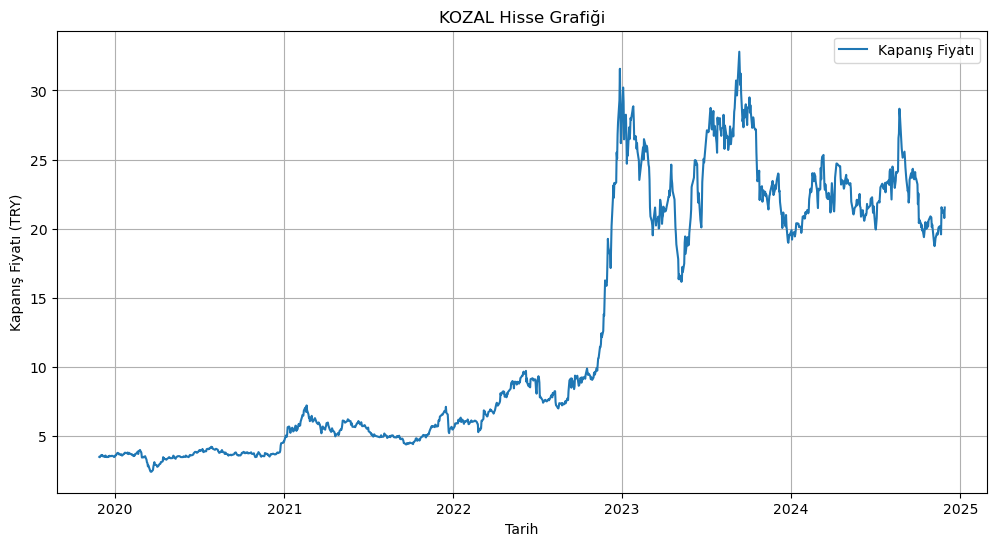

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['HGDG_TARIH'], df['HGDG_KAPANIS'], label='Kapanış Fiyatı')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı (TRY)')
plt.title(f"{stock} Hisse Grafiği")
plt.grid(True)
plt.legend()
plt.show()

#### 30 Günlük Hareketli Ortalama

In [14]:
MA_30 = df['HGDG_KAPANIS'].rolling(window=30).mean()

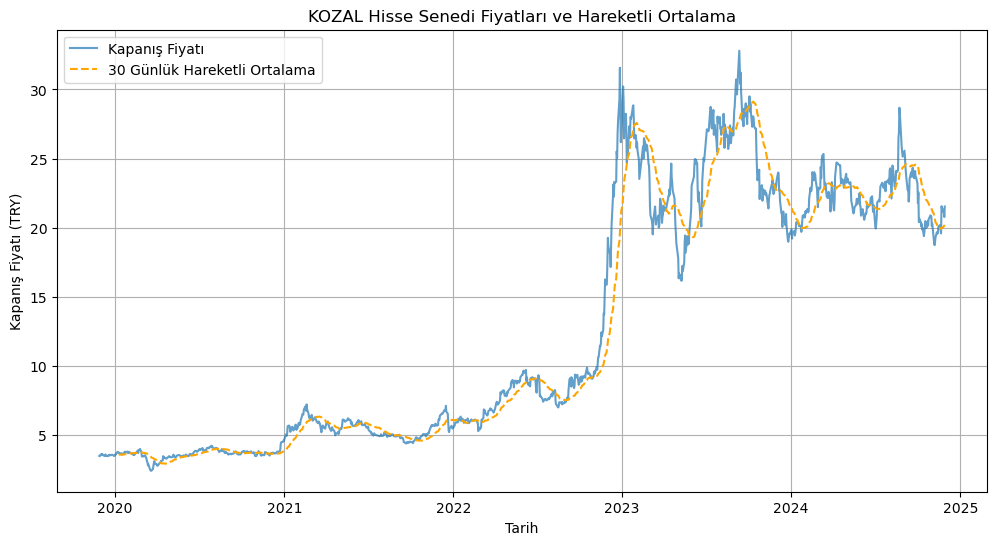

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df['HGDG_TARIH'], df['HGDG_KAPANIS'], label='Kapanış Fiyatı', alpha=0.7)
plt.plot(df['HGDG_TARIH'], MA_30, label='30 Günlük Hareketli Ortalama', color='orange', linestyle='--')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı (TRY)')
plt.title(f"{stock} Hisse Senedi Fiyatları ve Hareketli Ortalama")
plt.grid(True)
plt.legend()
plt.show()

#### Fiyat ve Hacim Grafiği

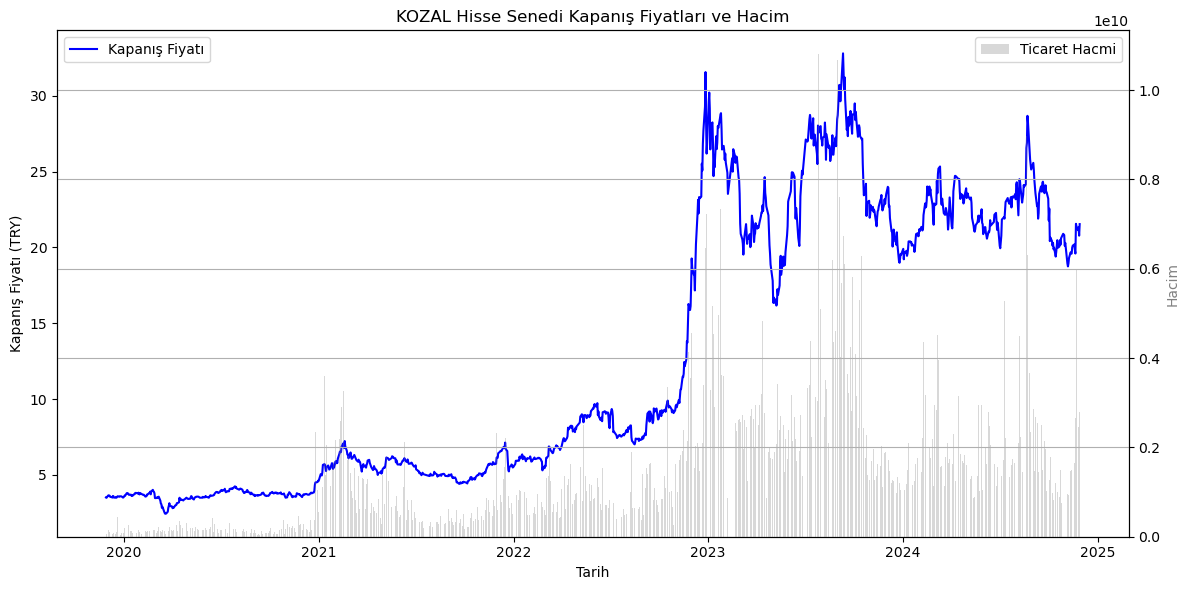

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df['HGDG_TARIH'], df['HGDG_KAPANIS'], color='blue', label='Kapanış Fiyatı')
ax1.set_xlabel('Tarih')
ax1.set_ylabel('Kapanış Fiyatı (TRY)')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  
ax2.bar(df['HGDG_TARIH'], df['HGDG_HACIM'], color='gray', alpha=0.3, label='Ticaret Hacmi')
ax2.set_ylabel('Hacim', color='gray')
ax2.tick_params(axis='y')
plt.title(f"{stock} Hisse Senedi Kapanış Fiyatları ve Hacim")
plt.grid(True)
fig.tight_layout()  
ax1.legend(loc='upper left')  
ax2.legend(loc='upper right')
plt.show()

#### Trend Grafiği

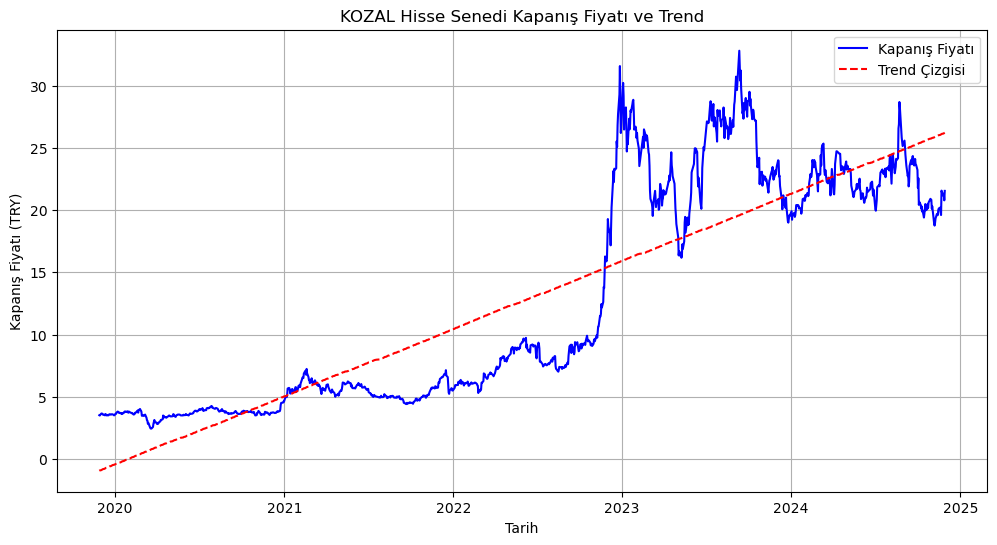

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(df['HGDG_TARIH'], df['HGDG_KAPANIS'], label='Kapanış Fiyatı', color='blue')
model = LinearRegression()
X = np.array(range(len(df))).reshape(-1, 1)  
y = df['HGDG_KAPANIS'].values
model.fit(X, y)
trend_line = model.predict(X)
plt.plot(df['HGDG_TARIH'], trend_line, label='Trend Çizgisi', color='red', linestyle='--')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı (TRY)')
plt.title(f"{stock} Hisse Senedi Kapanış Fiyatı ve Trend")
plt.grid(True)
plt.legend()
plt.show()

## Veri Ön İşleme

In [18]:
df.isnull().sum()  

HGDG_HS_KODU          0
HGDG_TARIH            0
HGDG_KAPANIS          0
HGDG_AOF              0
HGDG_MIN              0
HGDG_MAX              0
HGDG_HACIM            0
END_ENDEKS_KODU       0
END_TARIH             0
END_SEANS             0
END_DEGER             0
DD_DOVIZ_KODU         0
DD_DT_KODU            0
DD_TARIH              0
DD_DEGER              0
DOLAR_BAZLI_FIYAT     0
ENDEKS_BAZLI_FIYAT    0
DOLAR_HACIM           0
SERMAYE               0
HG_KAPANIS            0
HG_AOF                0
HG_MIN                0
HG_MAX                0
PD                    0
PD_USD                0
HAO_PD                4
HAO_PD_USD            4
HG_HACIM              0
DOLAR_BAZLI_MIN       0
DOLAR_BAZLI_MAX       0
DOLAR_BAZLI_AOF       0
dtype: int64

In [19]:
df.isnull().sum().sum()

8

In [20]:
df.dropna(inplace=True)

In [21]:
df.duplicated().sum()

0

## Özellik Mühendisliği

### Numerik Olmayan ve Çoklu Lineer Bağımlılığı Olan Veriler

In [22]:
df.columns

Index(['HGDG_HS_KODU', 'HGDG_TARIH', 'HGDG_KAPANIS', 'HGDG_AOF', 'HGDG_MIN', 'HGDG_MAX', 'HGDG_HACIM', 'END_ENDEKS_KODU', 'END_TARIH', 'END_SEANS', 'END_DEGER', 'DD_DOVIZ_KODU', 'DD_DT_KODU', 'DD_TARIH', 'DD_DEGER', 'DOLAR_BAZLI_FIYAT', 'ENDEKS_BAZLI_FIYAT', 'DOLAR_HACIM', 'SERMAYE', 'HG_KAPANIS', 'HG_AOF', 'HG_MIN', 'HG_MAX', 'PD', 'PD_USD', 'HAO_PD', 'HAO_PD_USD', 'HG_HACIM', 'DOLAR_BAZLI_MIN', 'DOLAR_BAZLI_MAX', 'DOLAR_BAZLI_AOF'], dtype='object')

In [23]:
drop_columns = ['HGDG_HS_KODU', 'END_ENDEKS_KODU', 'END_TARIH', 'END_SEANS', 'DD_DOVIZ_KODU', 'DD_DT_KODU', 'DD_TARIH', 'DOLAR_BAZLI_FIYAT', 'ENDEKS_BAZLI_FIYAT', 'DOLAR_HACIM', 'HG_KAPANIS', 'HG_AOF', 'HG_MIN', 'HG_MAX', 'PD_USD', 'HAO_PD', 'HAO_PD_USD', 'HG_HACIM', 'DOLAR_BAZLI_MIN', 'DOLAR_BAZLI_MAX', 'DOLAR_BAZLI_AOF']

In [24]:
df.drop(columns=drop_columns, inplace=True)

- Sayısal olmayan veriler ile beraber çoklu lineer bağımlılıkları bulunanan (Hisse fiyat, döviz kuru ve hisse fiyatının döviz karşılığı vb.)kolondarda veri setinden çıkartıldı. 

In [25]:
df.head()

,HGDG_TARIH,HGDG_KAPANIS,HGDG_AOF,HGDG_MIN,HGDG_MAX,HGDG_HACIM,END_DEGER,DD_DEGER,SERMAYE,PD
0,2019-11-28,3.5157,3.5044,3.4801,3.5253,44070567.0000,1071.2618,5.7682,152500000.0000,11269750232.6965
1,2019-11-29,3.4920,3.5000,3.4777,3.5490,53901233.0000,1069.0368,5.7507,152500000.0000,11193500232.6965
2,2019-12-02,3.6371,3.5971,3.4967,3.6918,153096964.0000,1080.0430,5.7529,152500000.0000,11658624534.6069
3,2019-12-03,3.6585,3.6960,3.6180,3.7631,139328166.0000,1067.8987,5.7468,152500000.0000,11727250232.6965
4,2019-12-04,3.6109,3.6412,3.6038,3.6989,117333452.0000,1077.0132,5.7463,152500000.0000,11574750232.6965


### Korelasyon Matrisi

In [26]:
correlation_matrix = df.corr(numeric_only=True)

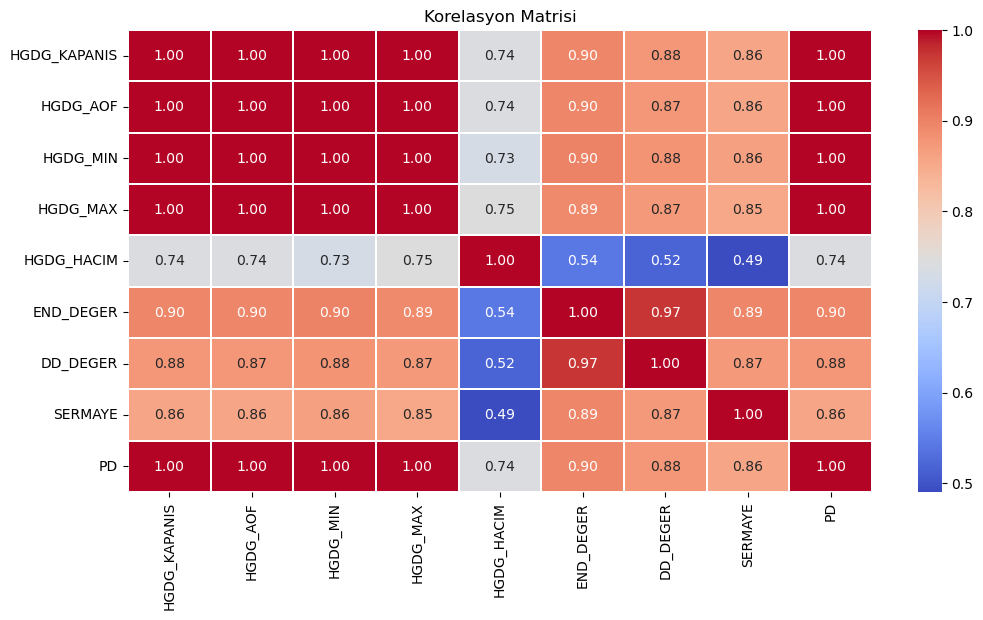

In [27]:
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.01)
plt.title('Korelasyon Matrisi')
plt.show()

In [28]:
threshold_corr = 0.85
selected_corr = correlation_matrix[np.abs(correlation_matrix) > threshold_corr]
selected_corr.columns

Index(['HGDG_KAPANIS', 'HGDG_AOF', 'HGDG_MIN', 'HGDG_MAX', 'HGDG_HACIM', 'END_DEGER', 'DD_DEGER', 'SERMAYE', 'PD'], dtype='object')

- Finansal verilerde yüksek korelasyon beklendiği için thresh değeri %85 seçildi ve üstü korelasyona sahip değerler seçildi.

### Features Importance

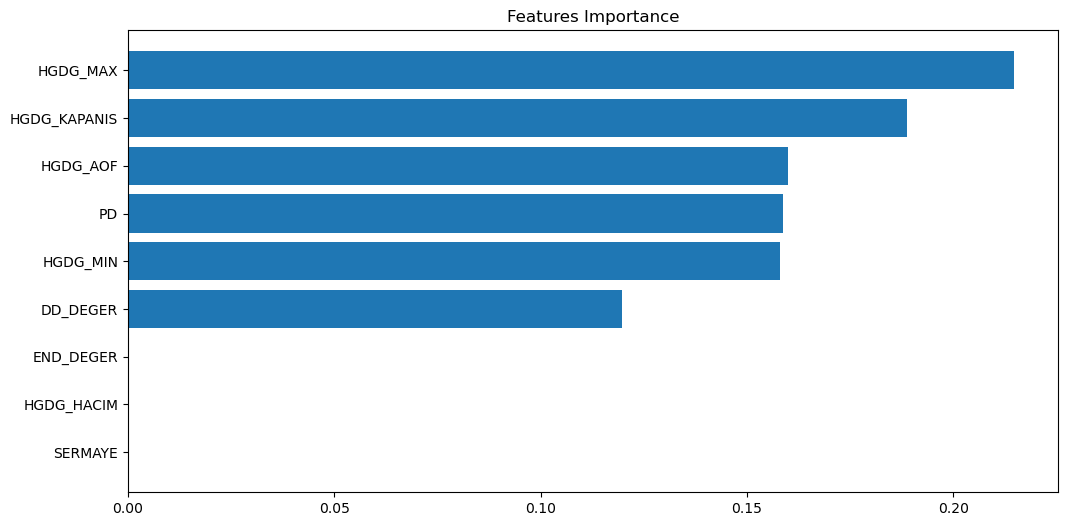

In [29]:
X = df.select_dtypes(include=['number'])
y = df['HGDG_KAPANIS'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Features Importance')
plt.show()

In [30]:
threshold_importance = 0.05
selected_features = importance_df[importance_df['Importance'] > threshold_importance]
selected_features['Feature'].values

array(['DD_DEGER', 'HGDG_MIN', 'PD', 'HGDG_AOF', 'HGDG_KAPANIS',
       'HGDG_MAX'], dtype=object)

- Başlangıç olarak threshold değeri %5 alınarak bu değer üstü veriler seçildi.

In [31]:
df_imp = df[selected_features['Feature'].values] # LSTM modelinde kullanılmak üzere seçildi

In [32]:
df_imp

,DD_DEGER,HGDG_MIN,PD,HGDG_AOF,HGDG_KAPANIS,HGDG_MAX
0,5.7682,3.4801,11269750232.6965,3.5044,3.5157,3.5253
1,5.7507,3.4777,11193500232.6965,3.5000,3.4920,3.5490
2,5.7529,3.4967,11658624534.6069,3.5971,3.6371,3.6918
3,5.7468,3.6180,11727250232.6965,3.6960,3.6585,3.7631
4,5.7463,3.6038,11574750232.6965,3.6412,3.6109,3.6989
...,...,...,...,...,...,...
1247,34.5263,21.4000,68533498778.3432,22.5300,21.4000,23.7000
1248,34.5806,21.1000,67700848045.3491,21.4700,21.1400,21.8400
1249,34.6349,21.0800,68277299022.6746,21.4860,21.3200,21.9600
1250,34.6351,20.7600,66547952198.9822,21.1080,20.7800,21.5800


## XGBoost

### Veri Hazırlık

In [33]:
df_xgb = df.drop(columns=['HGDG_TARIH'])
X_xgb = df_xgb.drop(columns=['HGDG_KAPANIS'])
y_xgb = df_xgb['HGDG_KAPANIS']

### Veri Seti Bölme (Train - Test Split)

In [34]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)

### Model Tasarımı

In [35]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

### KFold Cross Validation

In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5 katmanlı yapı kuruldu

In [37]:
cv_results = cross_val_score(model_xgb, X_xgb, y_xgb, cv=kf, scoring='neg_mean_squared_error')

In [38]:
cv_rmse = np.sqrt(-cv_results) # MSE negatif döndüğü için işaret değiştirilir

In [39]:
print(f'Cross Validation XGBoost RMSE: {cv_rmse.mean()}')

Cross Validation XGBoost RMSE: 0.11978575791977315


### Model Eğitimi

In [40]:
eval_set = [(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)]

In [41]:
model_xgb.fit(X_train_xgb, y_train_xgb, eval_set=eval_set)

[0]	validation_0-rmse:8.10907	validation_1-rmse:8.01893
[1]	validation_0-rmse:7.31054	validation_1-rmse:7.22814
[2]	validation_0-rmse:6.59119	validation_1-rmse:6.51632
[3]	validation_0-rmse:5.94257	validation_1-rmse:5.87749
[4]	validation_0-rmse:5.35826	validation_1-rmse:5.30265
[5]	validation_0-rmse:4.83153	validation_1-rmse:4.78280
[6]	validation_0-rmse:4.35695	validation_1-rmse:4.31252
[7]	validation_0-rmse:3.92925	validation_1-rmse:3.88804
[8]	validation_0-rmse:3.54364	validation_1-rmse:3.50890
[9]	validation_0-rmse:3.19622	validation_1-rmse:3.16825
[10]	validation_0-rmse:2.88307	validation_1-rmse:2.85894
[11]	validation_0-rmse:2.60107	validation_1-rmse:2.58035
[12]	validation_0-rmse:2.34639	validation_1-rmse:2.33053
[13]	validation_0-rmse:2.11701	validation_1-rmse:2.10411
[14]	validation_0-rmse:1.91017	validation_1-rmse:1.89941
[15]	validation_0-rmse:1.72386	validation_1-rmse:1.71579
[16]	validation_0-rmse:1.55593	validation_1-rmse:1.54896
[17]	validation_0-rmse:1.40459	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Model Tahminleme

In [42]:
predictions_xgb = model_xgb.predict(X_test_xgb)

### Tahmin Sonuçları ve Model Performansı

In [43]:
results_df_xgb = pd.DataFrame({
    'Gerçek Fiyat': y_test_xgb.values,  
    'Tahmin Edilen Fiyat': predictions_xgb  
})

results_df_xgb.head()

,Gerçek Fiyat,Tahmin Edilen Fiyat
0,7.1619,7.2062
1,24.9600,25.0672
2,28.7400,28.6667
3,3.5895,3.5990
4,5.8041,5.7574


In [44]:
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, predictions_xgb))  
mae_xgb = mean_absolute_error(y_test_xgb, predictions_xgb)
r2_xgb = r2_score(y_test_xgb, predictions_xgb)

print(f'XGBoost MAE: {mae_xgb}')
print(f'XGBoost RMSE: {rmse_xgb}')
print(f'XGBoost R²: {r2_xgb}')

XGBoost MAE: 0.048068308299255305
XGBoost RMSE: 0.13165258962641774
XGBoost R²: 0.9997797753069019


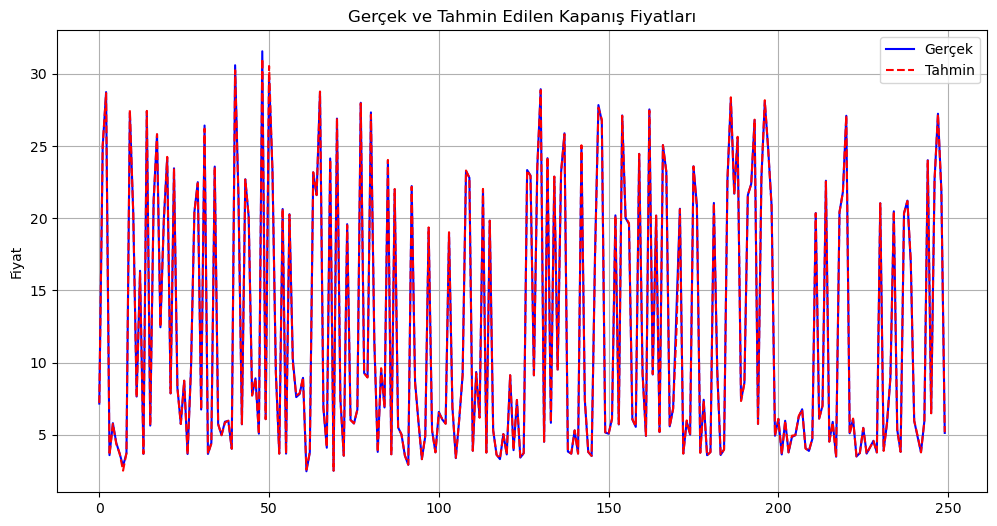

In [45]:
plt.figure(figsize=(12,6))
plt.plot(y_test_xgb.values, label="Gerçek", color='blue')
plt.plot(predictions_xgb, label="Tahmin", linestyle='--', color='red')
plt.title("Gerçek ve Tahmin Edilen Kapanış Fiyatları")
plt.ylabel('Fiyat')
plt.legend()
plt.grid()
plt.show()


## Standartlaştırma

- XGBoost ağaç bazlı bir olduğu için ölçeklendirme yapılmadı

In [46]:
data = df[['HGDG_KAPANIS']].values

In [47]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

- LSTM gibi modeller ile zaman serisi analizi yapılırken zaman bağımlılıkları ve bu bağımlılıklar arasındaki ilişkileri bozmamak için sadece hedef fiyat verisi ölçeklendirildi. 

In [48]:
data_imp = df_imp[['HGDG_KAPANIS']].values

In [49]:
scaler_imp = StandardScaler()
data_scaled_imp = scaler_imp.fit_transform(data_imp)

## LSTM 

### Zaman Serisini LSTM Formatına Çevirme

In [50]:
def create_dataset(df, time_step=60):
    """
    Zaman serisi tahminlemesi için veri seti oluşturur. 

    Parametreler:
    df: Giriş verisi (zaman serisi).
    time_step (int): Bir sonraki değeri tahmin etmek için kullanılan önceki zaman adımı sayısı (varsayılan 60).

    Dönen Değerler:
    X (np.array): Özellikler (önceki zaman adımlarının sıralamaları).
    y (np.array): Hedef (bir sonraki zaman adımındaki değer).
    """
    X, y = [], []
    for i in range(len(df) - time_step - 1):
        X.append(df[i:(i + time_step), 0]) 
        y.append(df[i + time_step, 0])      
    return np.array(X), np.array(y)

In [51]:
time_step = 60 # Zaman adımı seçimi
X, y = create_dataset(data_scaled, time_step)

In [52]:
X = X.reshape(X.shape[0], X.shape[1], 1) # Veriye LSTM modelinin beklediği 3.boyutu ekler.

In [53]:
X_imp, y_imp = create_dataset(data_scaled_imp, time_step)

In [54]:
X_imp = X_imp.reshape(X_imp.shape[0], X_imp.shape[1], 1)

### Veri Seti Bölme (Train - Test Split)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [56]:
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, shuffle=False)

### Model Tasarımı

In [57]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Olcay\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
model_imp = Sequential()
model_imp.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_imp.shape[1], 1)))
model_imp.add(Dense(units=1))
model_imp.compile(optimizer='adam', loss='mean_squared_error')

### Model Eğitimi

In [59]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.4793 - val_loss: 0.0505
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0280 - val_loss: 0.0300
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0186 - val_loss: 0.0262
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0147 - val_loss: 0.0233
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0123 - val_loss: 0.0174
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0113 - val_loss: 0.0134
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0102 - val_loss: 0.0140
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0098 - val_loss: 0.0254
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0096 - val_loss: 0.0163
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0090 - val_loss: 0.0115
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

In [60]:
model_imp.fit(X_train_imp, y_train_imp, epochs=20, batch_size=32, validation_data=(X_test_imp, y_test_imp))

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.3166 - val_loss: 0.0284
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0231 - val_loss: 0.0383
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0154 - val_loss: 0.0217
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0130 - val_loss: 0.0162
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0108 - val_loss: 0.0213
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0108 - val_loss: 0.0208
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0110 - val_loss: 0.0186
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0094 - val_loss: 0.0194
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0091 - val_loss: 0.0128
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

### Model Tahminleme

In [61]:
# Standart Scaler uygulanmış verinin çıktılarını tekrar orjinal ölçeğinne döndürür.
predictions = model.predict(X_test)
predictions_transform = scaler.inverse_transform(predictions) 
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [62]:
predictions_imp = model_imp.predict(X_test_imp)
predictions_transform_imp = scaler_imp.inverse_transform(predictions_imp) 
y_test_imp = scaler_imp.inverse_transform(y_test_imp.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


### Tahmin Sonuçları ve Model Performansı

In [63]:
test_dates = df['HGDG_TARIH'][-len(y_test):]
results_df = pd.DataFrame({
    'Tarih': test_dates,
    'Gerçek Fiyat': y_test.flatten(),
    'Tahmin Edilen Fiyat': predictions_transform.flatten()
})


results_df.head()

,Tarih,Gerçek Fiyat,Tahmin Edilen Fiyat
1012,2023-12-13,21.0600,22.3484
1013,2023-12-14,20.0600,21.8541
1014,2023-12-15,20.7400,21.2288
1015,2023-12-18,21.1800,20.9419
1016,2023-12-19,20.4000,20.9240


In [64]:
test_dates_imp = df['HGDG_TARIH'][-len(y_test_imp):]
results_df_imp = pd.DataFrame({
    'Tarih': test_dates_imp,
    'Gerçek Fiyat': y_test_imp.flatten(),
    'Tahmin Edilen Fiyat': predictions_transform_imp.flatten()
})


results_df_imp.head()

,Tarih,Gerçek Fiyat,Tahmin Edilen Fiyat
1012,2023-12-13,21.0600,22.1148
1013,2023-12-14,20.0600,21.5983
1014,2023-12-15,20.7400,20.9373
1015,2023-12-18,21.1800,20.6696
1016,2023-12-19,20.4000,20.6893


In [65]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, predictions_transform))  
mae_lstm = mean_absolute_error(y_test, predictions_transform)
r2_lstm = r2_score(y_test, predictions_transform)

print(f'LSTM MAE: {mae_lstm}')
print(f'LSTM RMSE: {rmse_lstm}')
print(f'LSTM R²: {r2_lstm}')

LSTM MAE: 0.6427547474067753
LSTM RMSE: 0.8494601778997521
LSTM R²: 0.7770000914594616


In [66]:
rmse_lstm_imp = np.sqrt(mean_squared_error(y_test_imp, predictions_transform_imp))  
mae_lstm_imp = mean_absolute_error(y_test_imp, predictions_transform_imp)
r2_lstm_imp = r2_score(y_test_imp, predictions_transform_imp)

print(f'LSTM MAE: {mae_lstm_imp}')
print(f'LSTM RMSE: {rmse_lstm_imp}')
print(f'LSTM R²: {r2_lstm_imp}')

LSTM MAE: 0.5988694952315642
LSTM RMSE: 0.8068166748591942
LSTM R²: 0.7988276138488045


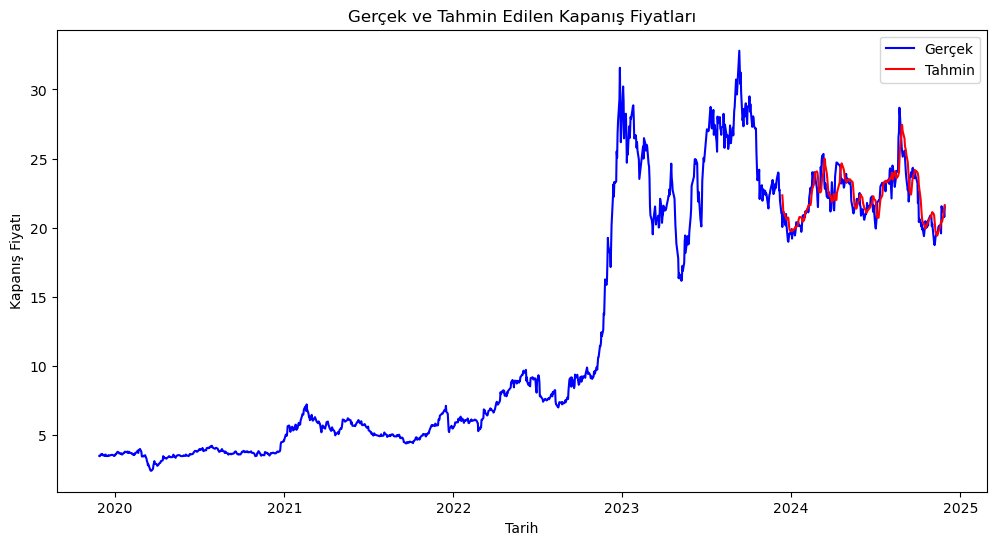

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df['HGDG_TARIH'], df['HGDG_KAPANIS'], label='Gerçek', color='blue')
plt.plot(test_dates, predictions_transform, label='Tahmin', color='red')
plt.title("Gerçek ve Tahmin Edilen Kapanış Fiyatları")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.legend()
plt.show()

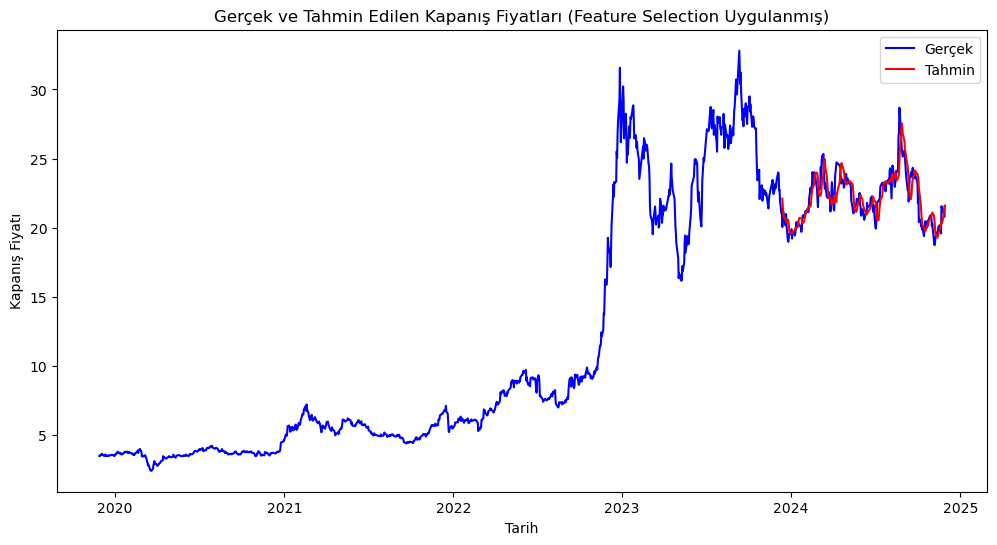

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(df['HGDG_TARIH'], df_imp['HGDG_KAPANIS'], label='Gerçek', color='blue')
plt.plot(test_dates_imp, predictions_transform_imp, label='Tahmin', color='red')
plt.title("Gerçek ve Tahmin Edilen Kapanış Fiyatları (Feature Selection Uygulanmış)")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")
plt.legend()
plt.show()